# 卷积神经网络（LeNet）

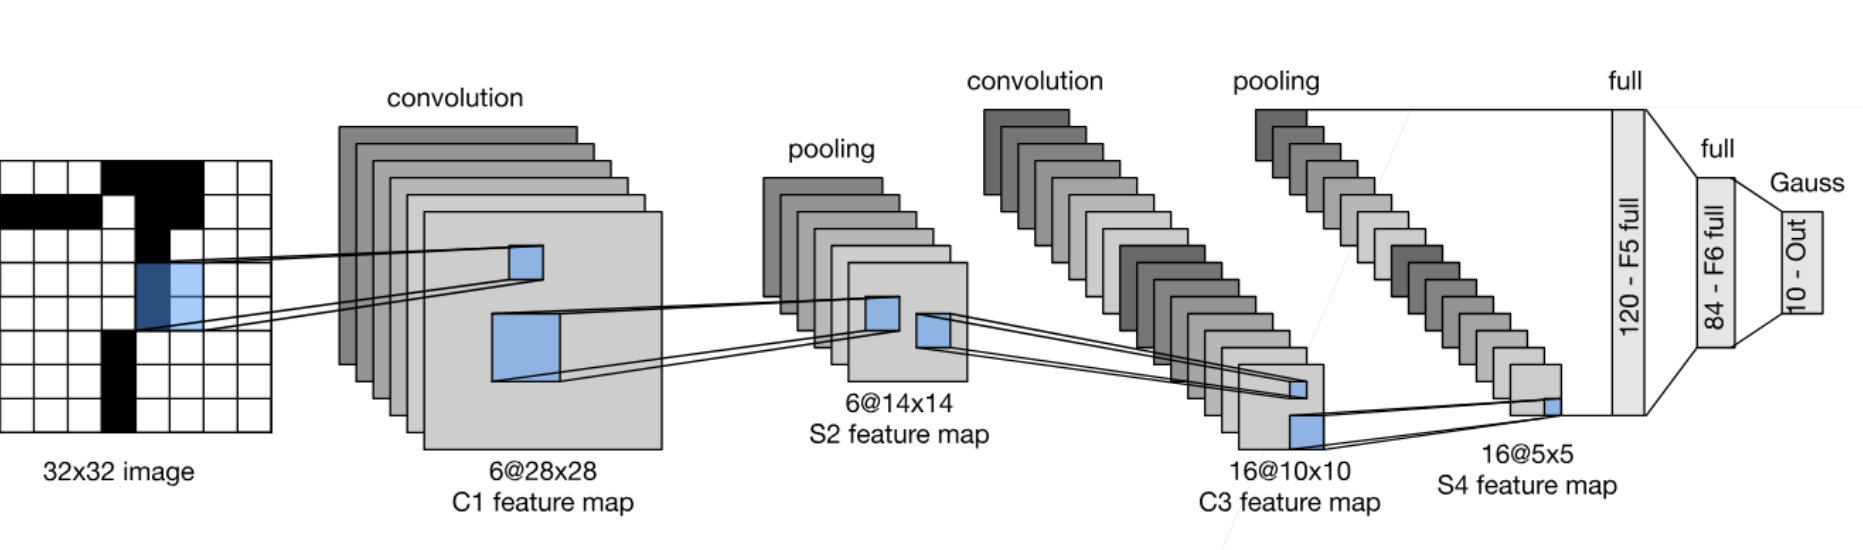

## 构造模型

In [3]:
# LeNet-5由两部分组成，卷积编码器和全连接层密集块。
import torch
from torch import nn
from d2l import torch as d2l

class Reshape(torch.nn.Module):
    def forward(self,x):
        #forward函数中会看到view函数的作用，这个是reshape,-1就是批量大小保持不变，不用管他
        return x.view(-1,1,28,28)

#相当于两个卷积层（卷积+激活+平均池化）+具有两个隐藏单元的多层感知机
#我们对原始模型做了一点小改动，去掉了最后一层的高斯激活。除此之外，这个网络与最初的LeNet-5一致。
net=torch.nn.Sequential(Reshape(),
                    #这里原始图像是28*28，输入图像是32*32，做了一个填充
                       nn.Conv2d(1,6,kernel_size=5,padding=2),
                       nn.Sigmoid(),
                       nn.AvgPool2d(kernel_size=2,stride=2),
                       nn.Conv2d(6,16,kernel_size=5),
                       nn.Sigmoid(),
                       nn.AvgPool2d(kernel_size=2,stride=2),
                        # 默认情况下，形状为（批量大小，通道数，高度，宽度）的输入，
                       # 转换为形状为（批量大小，通道数*高度*宽度）的输入
                        #最低微的维度也就是batch不变
                       nn.Flatten(),
                      #这里需要手动计算
                       nn.Linear(16*5*5,120),
                       nn.Sigmoid(),
                       nn.Linear(120,84),
                       nn.Sigmoid(),
                       nn.Linear(84,10))

## 检查模型

In [4]:
#我们将一个大小为的单通道（黑白）图像通过LeNet。通过在每一层打印输出的形状，我们可以检查模型
#可以知道每层的尺寸是多少
#每一个通道信息可以认为是一个模式
#卷积层不断压缩压缩，加到通道里面，通道一直增加，高宽一直减少，这个思想没有变化
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [6]:
batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size=batch_size)

In [7]:
#对evaluate_accuracy修改，在GPU上计算精度
#由于完整的数据集位于内存中，因此在模型使用GPU计算数据集之前，我们需要将其复制到显存中。
def evaluate_accuracy_gpu(net, data_iter, device=None):  
    if isinstance(net, torch.nn.Module):
        net.eval()#设置为评估模式，不计算梯度
        #如果没有指定device，就把第一个参数拿出来，看看这个模型放到哪个上面
        if not device:
            device = next(iter(net.parameters())).device
    #正确预测的数量，总的数量
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        #x是列表就遍历
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            #x是tensor就直接放到GPU
            X = X.to(device)
        #y也放到GPU上
        y = y.to(device)
        #正确样本个数
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

## 训练模型

In [8]:
#为了使用GPU，对训练函数作一点修改，多了一个device
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    #xavier这个初始化，保证输入输出的方差一开始是差不多大的，不要一开始就炸了
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    #把所有的参数放到GPU上
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        #x和y分别指的是图像和标签
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.458, train acc 0.829, test acc 0.826
50811.6 examples/sec on cuda:0


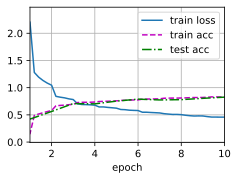

In [9]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
#一秒5万个数据 打印图、验证都耗费了时间，所以实际上看上去没有马上跑出来
#训练精度和测试精度基本是重合的，基本没有过拟合，但是可能会过拟合。

# 答疑

- 卷积神经网络LeNet和MLP精度差不多，卷积稍好一点，过拟合现象比MLP小，但是模型取值受限，模型比MLP小，模型复杂度低，等价于一个受限的MLP。
- 通常来说高宽减半的时候，减少的时候肯定会损失东西，会把通道数翻倍，可以表示的信息变多了
- view对数据的构造不会发生任何变化，只是形状发生改变，reshape比view的功能更高，可以把数据重新copy一下，比如拿出来1列、3列，实际上使用没有什么区别。
- 数据不大的时候（小于200*200）可以用MLP，MLP快，数据大的时候要用CNN
- 3D卷积通常会多了一个时序在里面
- cnn visualization->cnn explainer这个网站上可以看到卷积网络到底学到了什么
- 输出通道太大会overfiting,中间通道的大小是和数据复杂度相关的
- 真实做的时候是在一个很大的数据集上训练好的模型，再来用到一个小数据集上，进行微调。
- 训练后的权重能做visualizaition,看起来好看
- 卷积本身是一个结构化的东西，非结构化东西比如图片、语音、文本，可以通过结构化（卷积）抽取非结构化的语义信息。如果数据是结构化的（把图片做成结构化的），也可以用卷积构造结构化的模型，神经网络是一门语言。